# Setup

In [0]:
!pip install easy-vqa>=1.0

In [4]:
from easy_vqa import get_train_questions, get_test_questions, get_answers
from easy_vqa import get_train_image_paths, get_test_image_paths
import IPython.display as ipy
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Multiply, Embedding, Concatenate
from keras.models import load_model
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount=True)

PROJECT_LOC = ""

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Chirag
PROJECT_LOC = '/content/drive/My Drive/IIITD_Course/Sem_6/DL/DL_Group/Project_Easy_VQA'
os.chdir('/content/drive/My Drive/IIITD_Course/Sem_6/DL/DL_Group/Project_Easy_VQA')

In [0]:
# Prakhar
PROJECT_LOC = '/content/drive/My Drive/DL_Group/Project_Easy_VQA'
os.chdir('/content/drive/My Drive/DL_Group/Project_Easy_VQA')

In [0]:
# Akash
PROJECT_LOC = '/content/drive/My Drive/DL/Project_Easy_VQA'
# os.chdir('/content/drive/My Drive/DL/Project_Easy_VQA')

In [0]:
# Read question data
# (we already did this in the BOW section, remember?)
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()

# Read answer data
all_answers = get_answers()
num_answers = len(all_answers)

In [0]:
def load_and_proccess_image(image_path):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
  im = img_to_array(load_img(image_path))
  return im / 255 - 0.5

def read_images(paths):
  # paths is a dict mapping image ID to image path
  # Returns a dict mapping image ID to the processed image
  ims = {}
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path)
  return ims

train_ims = read_images(get_train_image_paths())
test_ims = read_images(get_test_image_paths())

In [0]:
# Create model input images
train_X_ims = [train_ims[id] for id in train_image_ids]
test_X_ims = [test_ims[id] for id in test_image_ids]

# Create model outputs
train_answer_indices = [all_answers.index(a) for a in train_answers]
test_answer_indices = [all_answers.index(a) for a in test_answers]
train_Y = to_categorical(train_answer_indices)
test_Y = to_categorical(test_answer_indices)

In [0]:
# Fit tokenizer on the training questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_qs)

embedding_length = 10
embedding_dim = 50

# Convert questions to GloVe indices
train_X_seqs = pad_sequences(tokenizer.texts_to_sequences(train_qs), maxlen=embedding_length)
test_X_seqs = pad_sequences(tokenizer.texts_to_sequences(test_qs), maxlen=embedding_length)

# We add one because the Keras Tokenizer reserves index 0 and never uses it.
vocab_size = len(tokenizer.word_index) + 1

In [9]:
embedding_vector = {}
f = open('Data/glove.6B.50d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:], dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:08, 48640.85it/s]


In [10]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 26/26 [00:00<00:00, 10989.81it/s]


# Training

In [0]:
# The CNN
im_input = Input(shape=(64, 64, 3))  
x1 = Conv2D(8, 3, padding='same')(im_input)
x1 = MaxPooling2D()(x1)
x1 = Conv2D(16, 3, padding='same')(x1)
x1 = MaxPooling2D()(x1)
x1 = Flatten()(x1)
x1 = Dense(32, activation='tanh')(x1)

In [0]:
# The question network
q_input = Input(shape=(embedding_length,))
x2 = Embedding(vocab_size, embedding_dim, input_length=embedding_length, trainable=True)(q_input)
x2 = Flatten()(x2)
x2 = Dense(64, activation='tanh')(x2)
x2 = Dense(32, activation='tanh')(x2)

In [0]:
out = Concatenate()([x1, x2]) # from previous section
out = Dense(64, activation='tanh')(out)
# num_answers will be defined below
out = Dense(num_answers, activation='softmax')(out)

model = Model(inputs=[im_input, q_input], outputs=out)
model.compile(
  Adam(lr=1e-3), # somewhat arbitrarily chosen
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [53]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 8)    224         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 10)           0                                            
____________________________________________________________________________________________

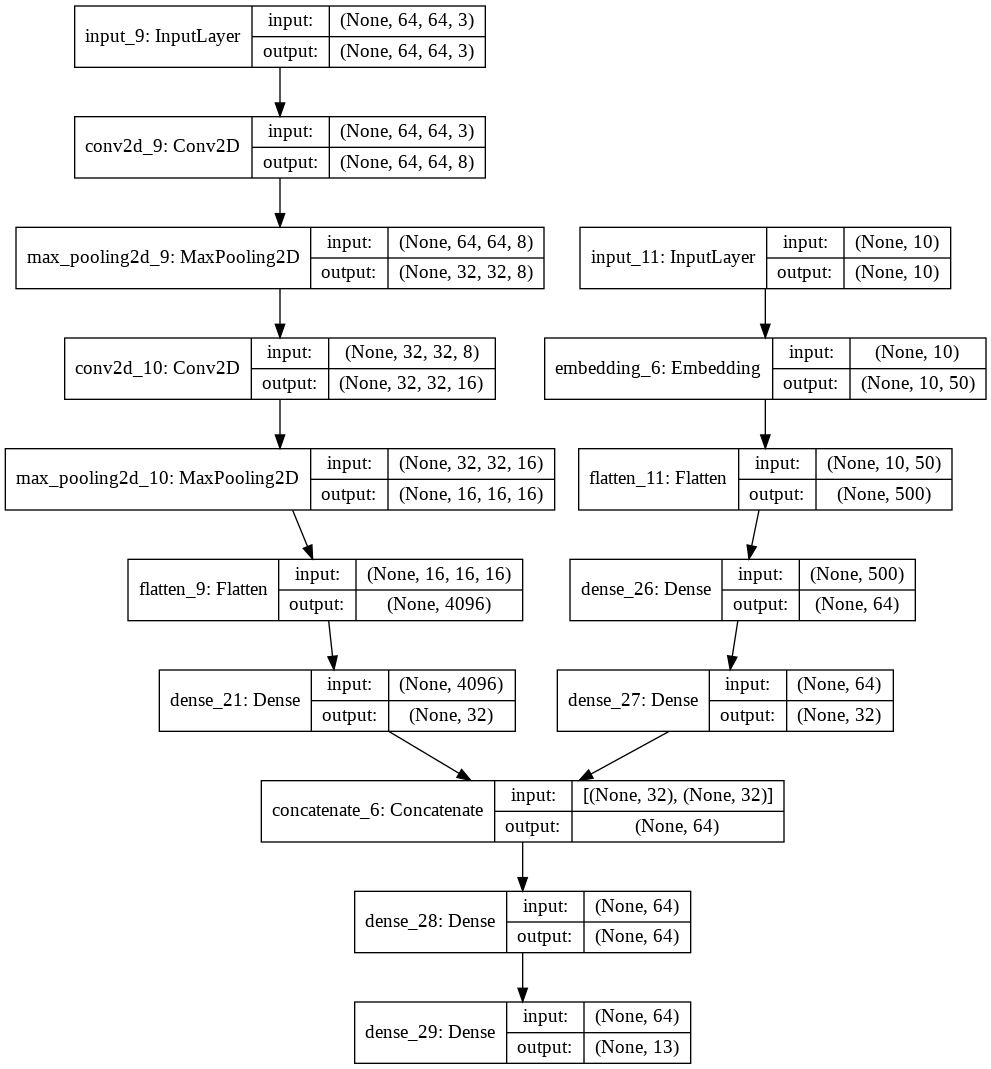

In [54]:
plot_model(model, show_shapes=True)

In [55]:
# Train the model!
history = model.fit(
  [train_X_ims, train_X_seqs], train_Y,
  validation_data=([test_X_ims, test_X_seqs], test_Y),
  shuffle=True,
  epochs=20,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38575 samples, validate on 9673 samples
Epoch 1/20
38575/38575 [==============================] - 8s 218us/step - loss: 0.5167 - accuracy: 0.8166 - val_loss: 0.4104 - val_accuracy: 0.8436
Epoch 2/20
38575/38575 [==============================] - 8s 210us/step - loss: 0.3450 - accuracy: 0.8615 - val_loss: 0.3833 - val_accuracy: 0.8442
Epoch 3/20
38575/38575 [==============================] - 8s 211us/step - loss: 0.2995 - accuracy: 0.8615 - val_loss: 0.4022 - val_accuracy: 0.8309
Epoch 4/20
38575/38575 [==============================] - 8s 209us/step - loss: 0.2400 - accuracy: 0.8840 - val_loss: 0.3183 - val_accuracy: 0.8701
Epoch 5/20
38575/38575 [==============================] - 8s 210us/step - loss: 0.1669 - accuracy: 0.9311 - val_loss: 0.2543 - val_accuracy: 0.9048
Epoch 6/20
38575/38575 [==============================] - 8s 210us/step - loss: 0.1011 - accuracy: 0.9696 - val_loss: 0.2124 - val_accuracy: 0.9318
Epoch 7/20
38575/38575 [==============================] - 8s 21

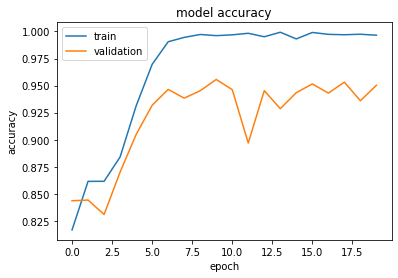

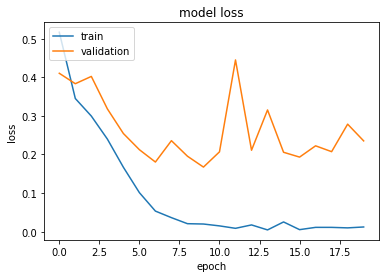

In [56]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
model.save('Data/self-embedding-prakhar.h5')